# Предсказание рака молочной железы на основе датасета Kaggle с применением логистической регрессии

## Описание датасета

Характеристики рассчитываются по оцифрованному изображению тонкоигольной аспирации (ТАБ) массы молочной железы. Они описывают характеристики ядер клеток, присутствующих на изображении.

### Описание колонок

* id - идентификатор пациента
* диагноз - M = злокачественное, B = доброкачественное

Для каждого клеточного ядра вычисляются десять вещественных признаков:

* радиус: расстояния от центра до точек по периметру
* текстура: стандартное отклонение значений шкалы серого
* периметр
* площадь
* гладкость: локальное изменение длины радиуса
* компактность: периметр^2 / площадь - 1,0
* вогнутость: выраженность вогнутых участков контура
* вогнутые точки: количество вогнутых частей контура
* симметрия
* фрактальная размерность: "приближение береговой линии" - 1

Дополнительно для каждого признака высчитвается среднее значение, стандартная ошибка и наихудшее(наибольшее значение) - итого 30 признаков для каждого изображения

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [67]:
df = pd.read_csv('cancer.csv', index_col=0)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [69]:
df = df.drop('Unnamed: 32', axis=1)

In [70]:
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

Число клеток, помеченных как Доброкачественные:  357
Число клеток, помеченных как Злокачественные:  212

% клеток, помеченных как Доброкачественные 62.74 %
% of клеток, помеченных как Злокачественные 37.26 %


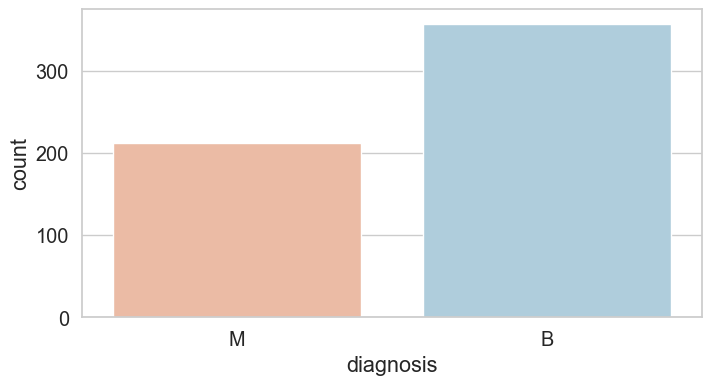

In [71]:
plt.figure(figsize=(8, 4))
sns.countplot(x = df['diagnosis'], palette='RdBu')

benign, malignant = df['diagnosis'].value_counts()
print('Число клеток, помеченных как Доброкачественные: ', benign)
print('Число клеток, помеченных как Злокачественные: ', malignant)
print('')
print('% клеток, помеченных как Доброкачественные', round(benign / len(df) * 100, 2), '%')
print('% of клеток, помеченных как Злокачественные', round(malignant / len(df) * 100, 2), '%')

Из 569 наблюдений 357 (или 62,7%) были признаны злокачественными, а остальные 212 (или 37,3%) — доброкачественными.

Взаимосвязь между 10 ключевыми атрибутами и диагностической переменной, используя только «средние» столбцы.

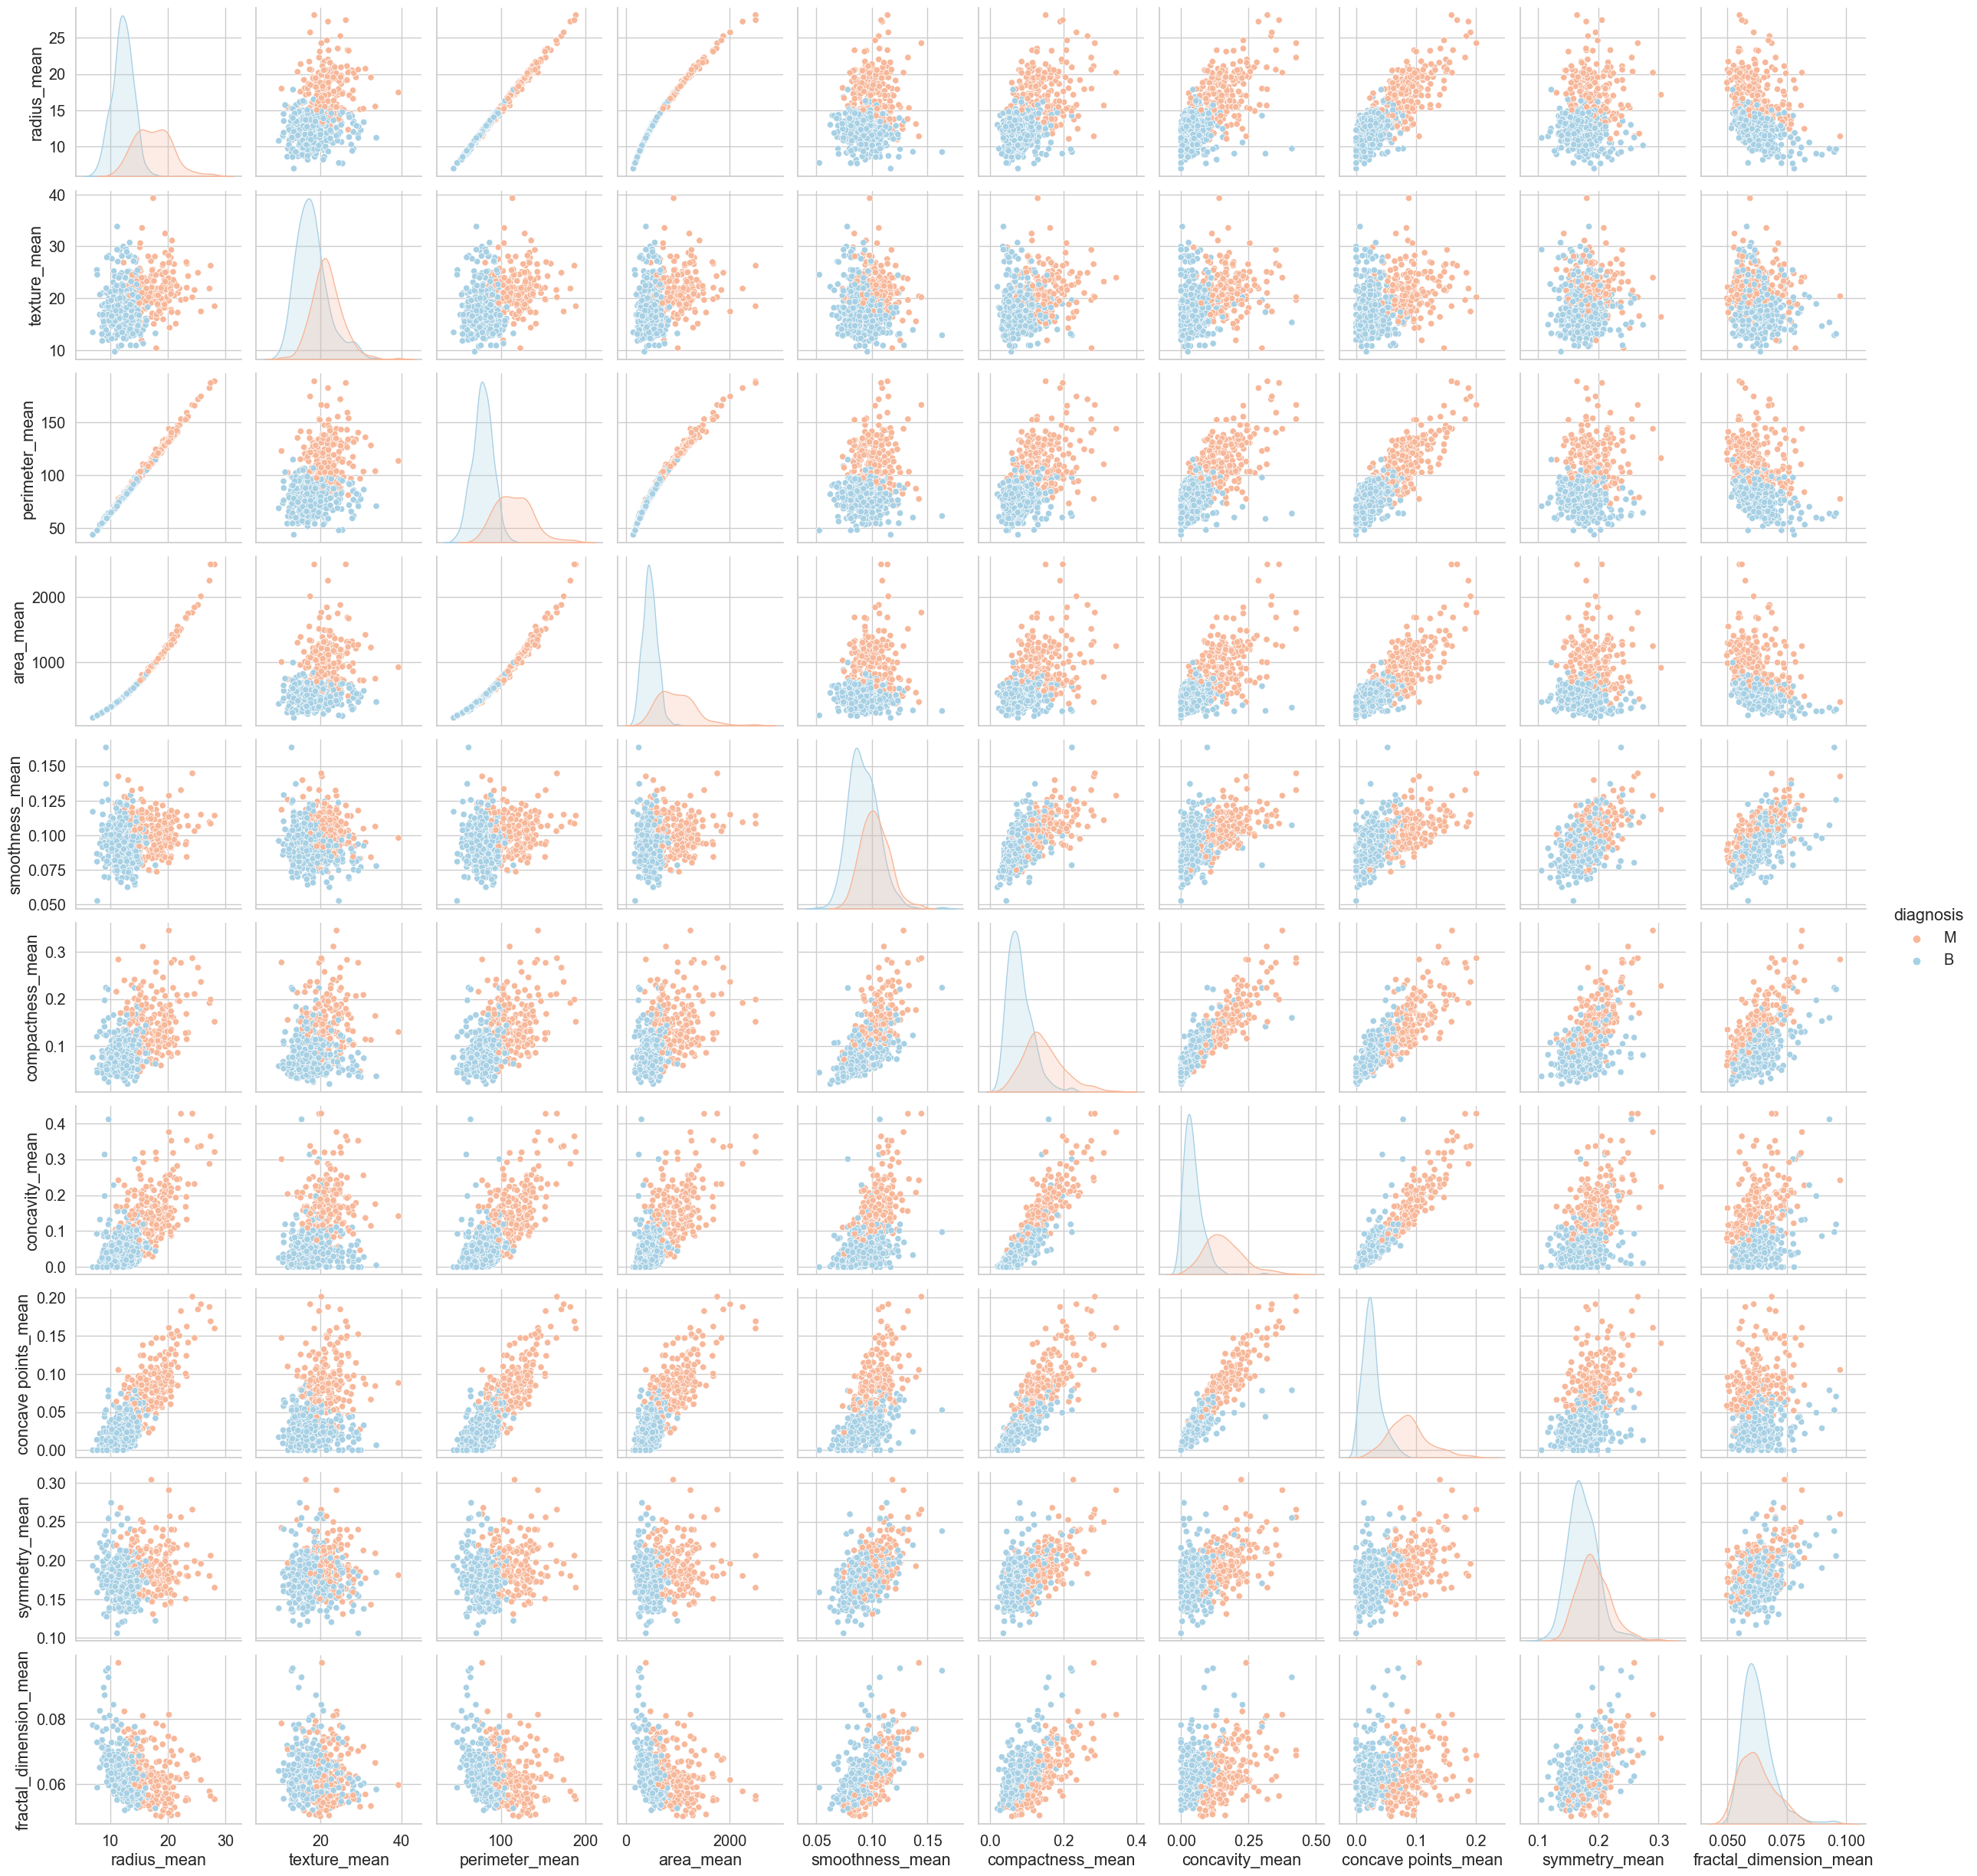

In [72]:
cols = ['diagnosis',
        'radius_mean',
        'texture_mean',
        'perimeter_mean',
        'area_mean',
        'smoothness_mean',
        'compactness_mean',
        'concavity_mean',
        'concave points_mean',
        'symmetry_mean',
        'fractal_dimension_mean']

sns.pairplot(data=df[cols], hue='diagnosis', palette='RdBu')

Почти идеально линейные закономерности между атрибутами радиуса, периметра и площади намекают на наличие мультиколлинеарности между этими переменными. Другой набор переменных, которые, возможно, подразумевают мультиколлинеарность, — это вогнутость, вогнутые точки и компактность.

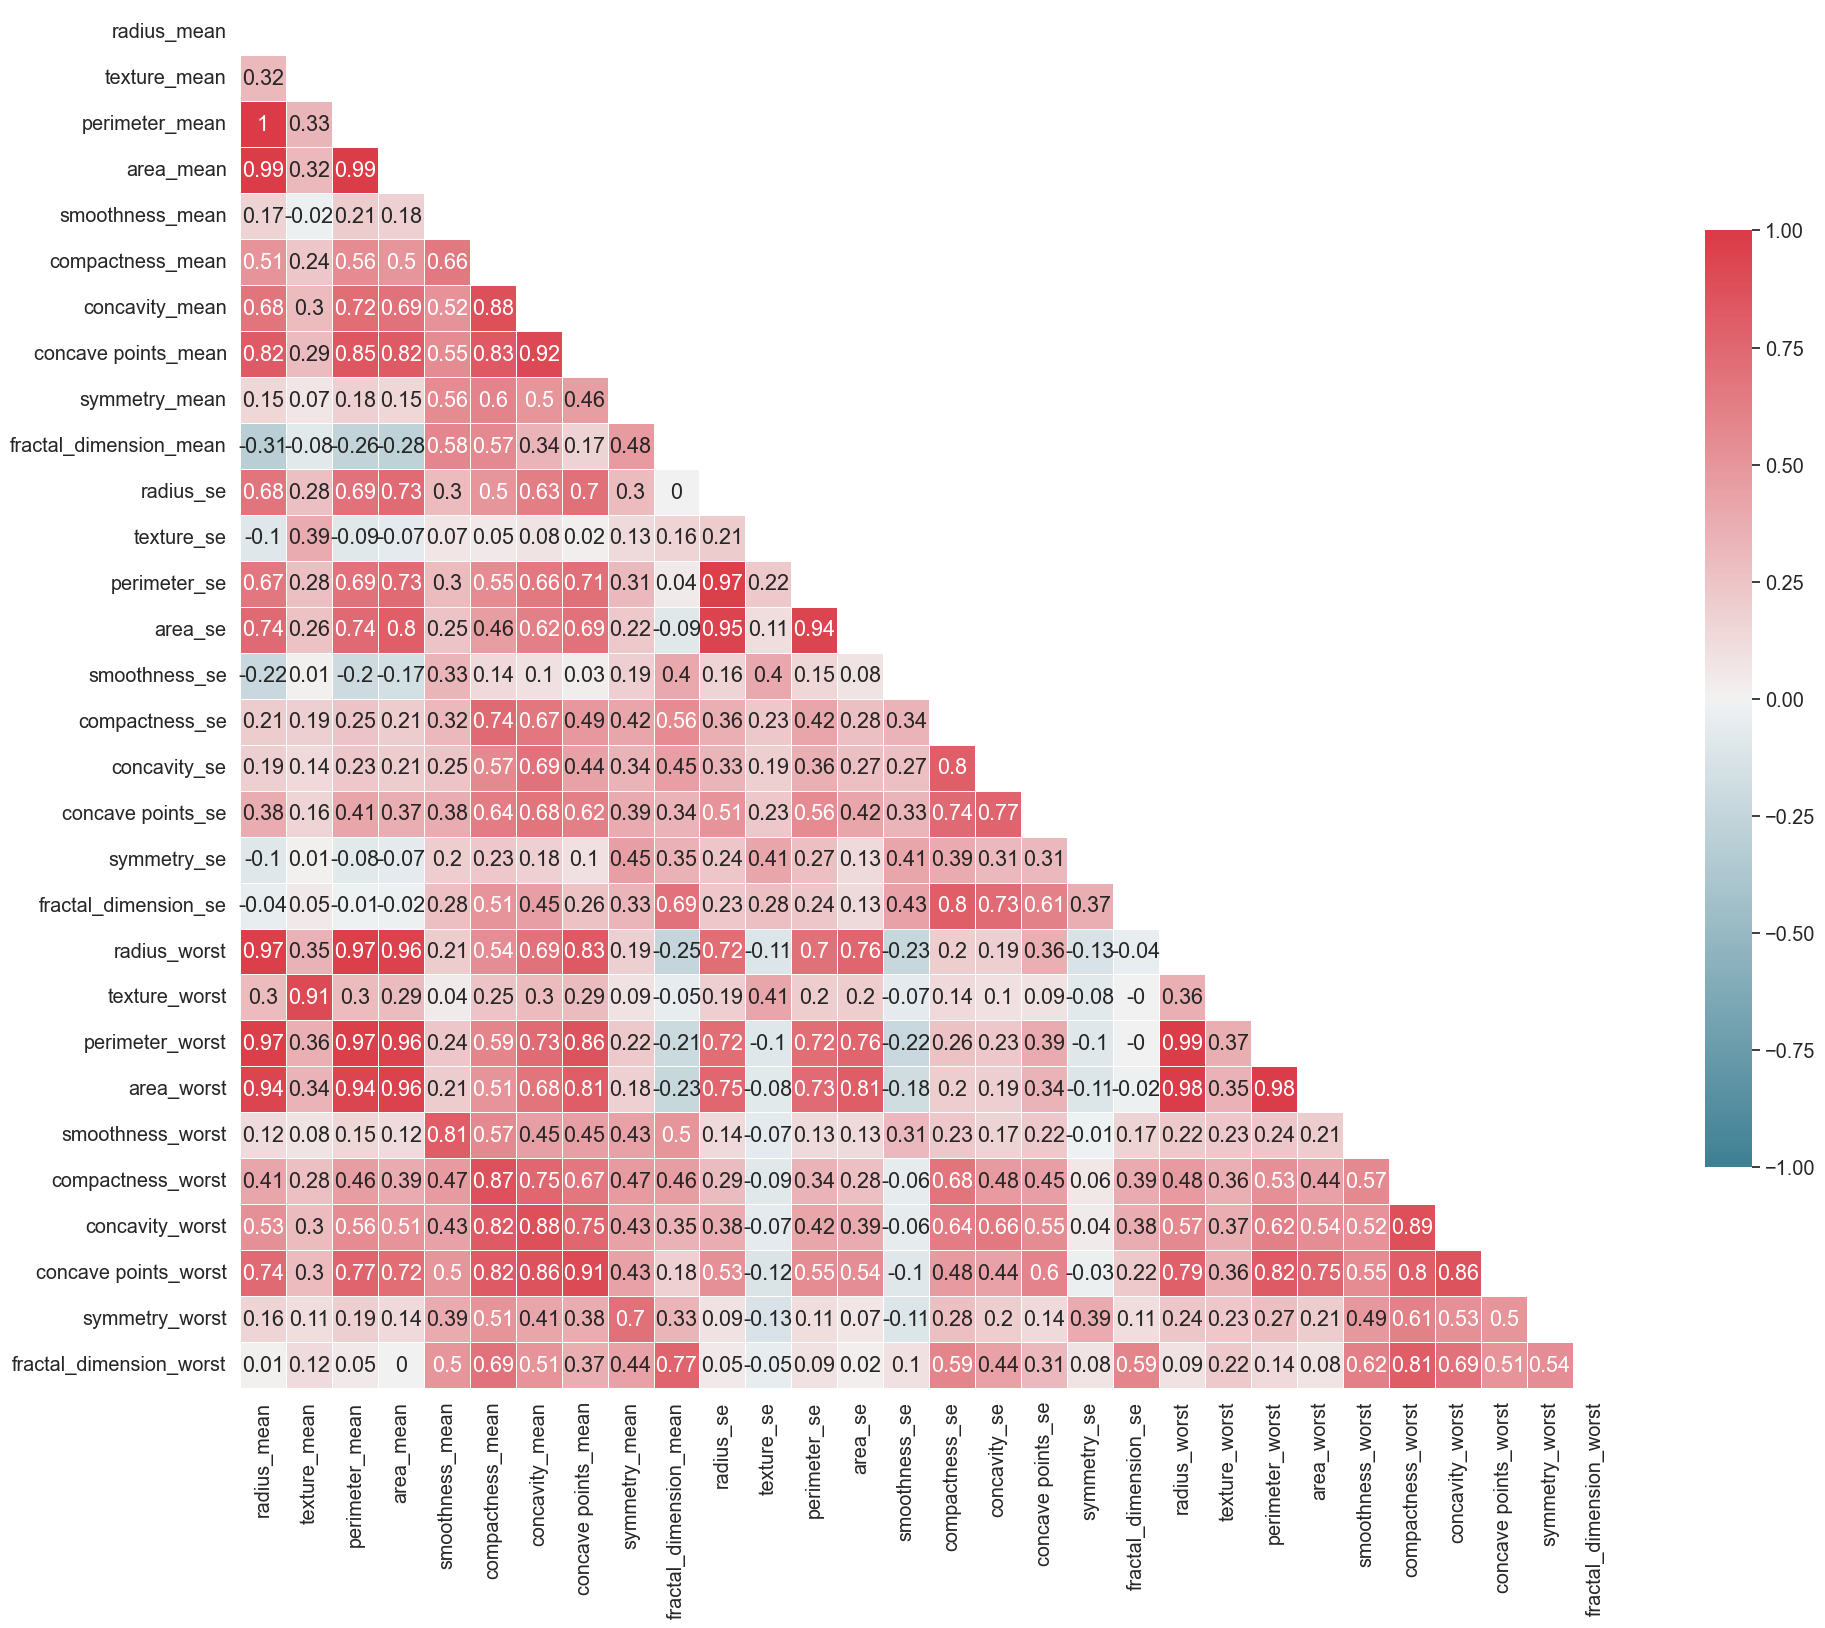

In [73]:
corr = df.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

Удаление атрибутов, не участвующих в обучении модели

In [74]:
cols = ['radius_worst',
        'texture_worst',
        'perimeter_worst',
        'area_worst',
        'smoothness_worst',
        'compactness_worst',
        'concavity_worst',
        'concave points_worst',
        'symmetry_worst',
        'fractal_dimension_worst']
df = df.drop(cols, axis=1)

cols = ['perimeter_mean',
        'perimeter_se',
        'area_mean',
        'area_se']
df = df.drop(cols, axis=1)

cols = ['concavity_mean',
        'concavity_se',
        'concave points_mean',
        'concave points_se']
df = df.drop(cols, axis=1)

df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se'],
      dtype='object')

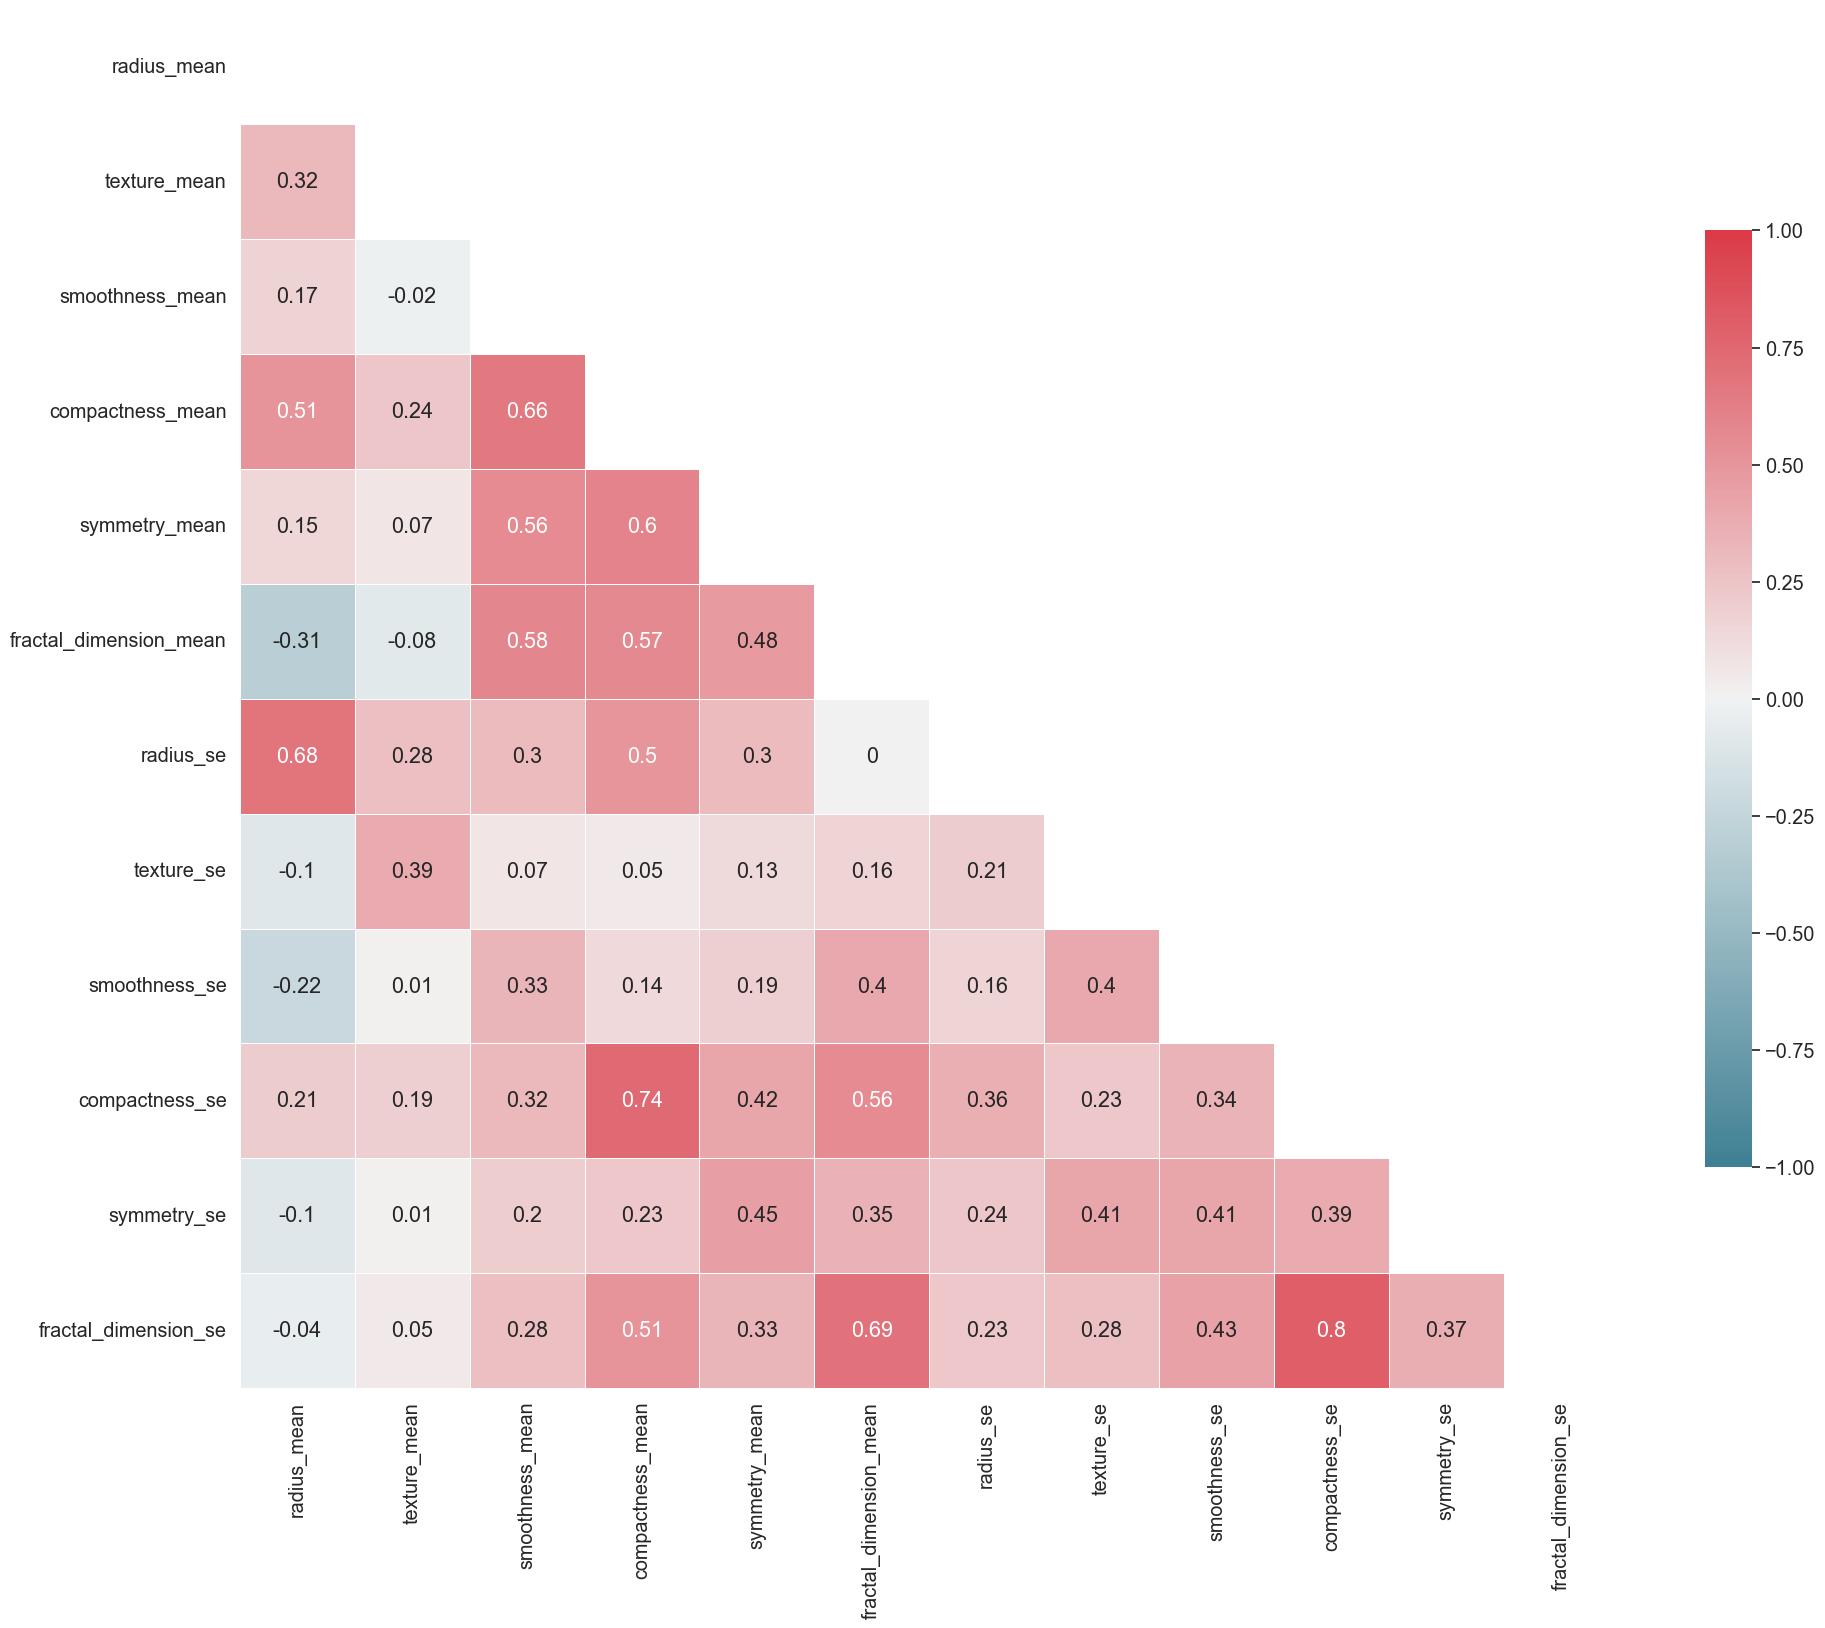

In [75]:
corr = df.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

### Разделение датасета на тренировочный и тестовый

In [76]:
X = df
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Формула логистической регрессии
Формула включает все переменные, которые были окончательно выбраны

In [77]:
cols = df.columns.drop('diagnosis')
formula = 'diagnosis ~ ' + ' + '.join(cols)
print(formula, '\n')

diagnosis ~ radius_mean + texture_mean + smoothness_mean + compactness_mean + symmetry_mean + fractal_dimension_mean + radius_se + texture_se + smoothness_se + compactness_se + symmetry_se + fractal_dimension_se 



In [78]:
model = smf.glm(formula=formula, data=X_train, family=sm.families.Binomial())
logistic_fit = model.fit()

print(logistic_fit.summary())

                        Generalized Linear Model Regression Results                         
Dep. Variable:     ['diagnosis[B]', 'diagnosis[M]']   No. Observations:                  455
Model:                                          GLM   Df Residuals:                      442
Model Family:                              Binomial   Df Model:                           12
Link Function:                                Logit   Scale:                          1.0000
Method:                                        IRLS   Log-Likelihood:                -59.967
Date:                              Wed, 15 Mar 2023   Deviance:                       119.93
Time:                                      11:26:00   Pearson chi2:                     143.
No. Iterations:                                   9   Pseudo R-squ. (CS):             0.6552
Covariance Type:                          nonrobust                                         
                             coef    std err          z      P>|z|    

### Предсказание модели

In [79]:
predictions = logistic_fit.predict(X_test)
predictions[1:6]

id
848406      0.341149
907915      0.998086
911201      0.973445
84799002    0.000357
8911164     0.924872
dtype: float64

Вводим границу для логистической регрессии

In [80]:
predictions_nominal = [ "M" if x < 0.5 else "B" for x in predictions]
predictions_nominal[1:6]

['M', 'B', 'B', 'M', 'B']

In [81]:
print(classification_report(y_test, predictions_nominal, digits=3))

cfm = confusion_matrix(y_test, predictions_nominal)

true_negative = cfm[0][0]
false_positive = cfm[0][1]
false_negative = cfm[1][0]
true_positive = cfm[1][1]

print('Confusion Matrix: \n', cfm, '\n')

print('True Negative:', true_negative)
print('False Positive:', false_positive)
print('False Negative:', false_negative)
print('True Positive:', true_positive)
print('Процент корректных предсказаний',
      round((true_negative + true_positive) / len(predictions_nominal) * 100, 1), '%')

              precision    recall  f1-score   support

           B      0.973     0.973     0.973        75
           M      0.949     0.949     0.949        39

    accuracy                          0.965       114
   macro avg      0.961     0.961     0.961       114
weighted avg      0.965     0.965     0.965       114

Confusion Matrix: 
 [[73  2]
 [ 2 37]] 

True Negative: 73
False Positive: 2
False Negative: 2
True Positive: 37
Процент корректных предсказаний 96.5 %
